In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind
from IPython.display import display

In [2]:
# Load data
df = pd.read_csv("post_pandemic_remote_work_health_impact_2025.csv")
df.head()

,Survey_Date,Age,Gender,Region,Industry,Job_Role,Work_Arrangement,Hours_Per_Week,Mental_Health_Status,Burnout_Level,Work_Life_Balance_Score,Physical_Health_Issues,Social_Isolation_Score,Salary_Range
0,2025-06-01,27,Female,Asia,Professional Services,Data Analyst,Onsite,64,Stress Disorder,High,3,Shoulder Pain; Neck Pain,2,$40K-60K
1,2025-06-01,37,Female,Asia,Professional Services,Data Analyst,Onsite,37,Stress Disorder,High,4,Back Pain,2,$80K-100K
2,2025-06-01,32,Female,Africa,Education,Business Analyst,Onsite,36,ADHD,High,3,Shoulder Pain; Eye Strain,2,$80K-100K
3,2025-06-01,40,Female,Europe,Education,Data Analyst,Onsite,63,ADHD,Medium,1,Shoulder Pain; Eye Strain,2,$60K-80K
4,2025-06-01,30,Male,South America,Manufacturing,DevOps Engineer,Hybrid,65,NaN,Medium,5,NaN,4,$60K-80K


In [3]:
# Filter to include only remote workers
df_remote = df[df["Work_Arrangement"] == "Remote"].copy()
df_remote.head()

,Survey_Date,Age,Gender,Region,Industry,Job_Role,Work_Arrangement,Hours_Per_Week,Mental_Health_Status,Burnout_Level,Work_Life_Balance_Score,Physical_Health_Issues,Social_Isolation_Score,Salary_Range
8,2025-06-01,30,Female,South America,Technology,Software Engineer,Remote,47,Anxiety,Medium,2,Neck Pain,4,$60K-80K
11,2025-06-01,64,Male,North America,Technology,Business Analyst,Remote,35,ADHD,Medium,3,Eye Strain; Wrist Pain,4,$40K-60K
13,2025-06-01,37,Male,Europe,Finance,UX Designer,Remote,59,Anxiety,High,5,Back Pain; Shoulder Pain; Wrist Pain,5,$60K-80K
14,2025-06-01,50,Male,Europe,Professional Services,Social Media Manager,Remote,64,Burnout,Medium,1,NaN,4,$60K-80K
19,2025-06-01,27,Female,Africa,Healthcare,Account Manager,Remote,43,NaN,Medium,1,NaN,4,$80K-100K


In [4]:
# Check for duplicates
print("Duplicates:", df_remote.duplicated().sum())

Duplicates: 0


In [5]:
# Quick look at nulls
print("Missing values per column:")
null_counts = df_remote.isnull().sum().reset_index()
null_counts.columns = ["Column", "Null Values"]
display(null_counts)

Missing values per column:


,Column,Null Values
0,Survey_Date,0
1,Age,0
2,Gender,0
3,Region,0
4,Industry,0
5,Job_Role,0
6,Work_Arrangement,0
7,Hours_Per_Week,0
8,Mental_Health_Status,163
9,Burnout_Level,0


In [6]:
# Take care of columns with missing values
df_remote["Mental_Health_Status"] = df_remote["Mental_Health_Status"].fillna("None")
df_remote["Physical_Health_Issues"] = df_remote["Physical_Health_Issues"].fillna("None")

null_counts = df_remote.isnull().sum().reset_index()
null_counts.columns = ["Column", "Null Values"]
display(null_counts)

,Column,Null Values
0,Survey_Date,0
1,Age,0
2,Gender,0
3,Region,0
4,Industry,0
5,Job_Role,0
6,Work_Arrangement,0
7,Hours_Per_Week,0
8,Mental_Health_Status,0
9,Burnout_Level,0


In [7]:
# Get all issues in Physical_Health_Issues, split by ;
issues = set(
    df_remote["Physical_Health_Issues"]
    .str.split(";")
    .apply(lambda x: [issue.strip() for issue in x if issue.strip()])
    .explode()
    .dropna()
    .unique()
)
issues.remove("None")
issues.add("No Physical Health Issues")

# One-hot encode selected health issues for remote workers, using True/False
df_remote["Physical_Health_Issues"] = (
    df_remote["Physical_Health_Issues"]
    .replace("None", "No Physical Health Issues")
    .astype(str)
)
for issue in issues:
    colname = issue.replace(" ", "_")
    df_remote[colname] = df_remote["Physical_Health_Issues"].apply(lambda x: issue in x)

In [8]:
# Categorical summaries (using display for better output)
categorical_cols = {
    "Gender",
    "Region",
    "Industry",
    "Job_Role",
    "Work_Arrangement",
    "Mental_Health_Status",
    "Burnout_Level",
    "Salary_Range",
}.union([issue.replace(" ", "_") for issue in issues])
numericals_cols = (
    set(df_remote.columns)
    .difference(categorical_cols)
    .difference({"Physical_Health_Issues", "Survey_Date"})
)

df_categorical = df_remote[list(categorical_cols)]
df_numerical = df_remote[list(numericals_cols)]

In [9]:
# Creating a dictionary to store the labeled dataframes
categorical_summary_dfs = {
    col: pd.concat(
        [
            df_categorical[col].value_counts(normalize=True),
            df_categorical[col].value_counts(),
        ],
        axis=1,
        keys=["proportion", "count"],
    )
    for col in df_categorical
}

# Concatenating along axis=0 with keys as column labels
categorical_summary_df = pd.concat(categorical_summary_dfs, axis=0)

# Displaying the dataframe
pd.set_option("display.max_rows", None)
display(categorical_summary_df)
pd.reset_option("display.max_rows")

proportion  count
Burnout_Level             High                            0.464286    273
                          Medium                          0.397959    234
                          Low                             0.137755     81
Mental_Health_Status      None                            0.277211    163
                          PTSD                            0.132653     78
                          Anxiety                         0.127551     75
                          ADHD                            0.120748     71
                          Stress Disorder                 0.120748     71
                          Depression                      0.113946     67
                          Burnout                         0.107143     63
Work_Arrangement          Remote                          1.000000    588
Gender                    Male                            0.498299    293
                          Female                          0.465986    274
                          Non-binary                      0.023810     14
                          Prefer not to say               0.011905      7
Region                    South America                   0.185374    109
                          Oceania                         0.175170    103
                          North America                   0.168367     99
                          Asia                            0.161565     95
                          Africa                          0.156463     92
                          Europe                          0.153061     90
Job_Role                  Operations Manager              0.052721     31
                          Research Scientist              0.052721     31
                          Quality Assurance               0.052721     31
                          Data Analyst                    0.051020     30
                          Product Manager                 0.049320     29
                          IT Support                      0.047619     28
                          Data Scientist                  0.047619     28
                          Social Media Manager            0.044218     26
                          Project Manager                 0.044218     26
                          Customer Service Manager        0.044218     26
                          UX Designer                     0.042517     25
                          Software Engineer               0.040816     24
                          Technical Writer                0.040816     24
                          Digital Marketing Specialist    0.040816     24
                          Consultant                      0.039116     23
                          Content Writer                  0.039116     23
                          Business Analyst                0.039116     23
                          HR Manager                      0.039116     23
                          Sales Representative            0.037415     22
                          Executive Assistant             0.035714     21
                          Financial Analyst               0.034014     20
                          DevOps Engineer                 0.034014     20
                          Account Manager                 0.028912     17
                          Marketing Specialist            0.022109     13
Industry                  Technology                      0.340136    200
                          Professional Services           0.161565     95
                          Manufacturing                   0.153061     90
                          Finance                         0.090136     53
                          Education                       0.078231     46
                          Healthcare                      0.052721     31
                          Customer Service                0.045918     27
                          Retail                          0.045918     27
                          Marketing                       0.

In [10]:
# Outlier checks
df_outliers = pd.DataFrame(
    {
        "Age < 18": df_numerical["Age"] < 18,
        "Age > 65": df_numerical["Age"] > 65,
        "Hours_Per_Week < 0": df_numerical["Hours_Per_Week"] < 0,
        "Hours_Per_Week > 80": df_numerical["Hours_Per_Week"] > 80,
    }
)
df_outliers = df_outliers.sum().reset_index()
df_outliers.columns = ["Condition", "Count"]
display(df_outliers)

,Condition,Count
0,Age < 18,0
1,Age > 65,0
2,Hours_Per_Week < 0,0
3,Hours_Per_Week > 80,0


## Exploratory Data Analysis (EDA) on Burnout in Remote Work

In [11]:
# Summary statistics for all numeric columns
display(df_numerical.describe())

# describe numerical columns based on Burnout level
for col in numericals_cols:
    print(f"Summary statistics for {col} by Burnout Level:")
    display(df_numerical.groupby(df_remote["Burnout_Level"])[col].describe())

,Hours_Per_Week,Work_Life_Balance_Score,Age,Social_Isolation_Score
count,588.000000,588.000000,588.000000,588.000000
mean,49.872449,2.993197,44.284014,3.496599
std,8.875001,1.207566,12.485738,1.147543
min,35.000000,1.000000,22.000000,1.000000
25%,42.750000,2.000000,34.000000,3.000000
50%,50.000000,3.000000,45.000000,4.000000
75%,57.000000,4.000000,55.000000,4.000000
max,65.000000,5.000000,65.000000,5.000000


Summary statistics for Hours_Per_Week by Burnout Level:


,count,mean,std,min,25%,50%,75%,max
Burnout_Level,,,,,,,,
High,273.0,49.769231,9.085068,35.0,42.0,50.0,57.0,65.0
Low,81.0,48.950617,8.549709,35.0,42.0,49.0,56.0,65.0
Medium,234.0,50.311966,8.745379,35.0,43.0,50.0,58.0,65.0


Summary statistics for Work_Life_Balance_Score by Burnout Level:


,count,mean,std,min,25%,50%,75%,max
Burnout_Level,,,,,,,,
High,273.0,3.036630,1.224195,1.0,2.0,3.0,4.0,5.0
Low,81.0,3.000000,1.214496,1.0,2.0,3.0,4.0,5.0
Medium,234.0,2.940171,1.188577,1.0,2.0,3.0,4.0,5.0


Summary statistics for Age by Burnout Level:


,count,mean,std,min,25%,50%,75%,max
Burnout_Level,,,,,,,,
High,273.0,44.498168,12.495330,22.0,34.0,45.0,56.0,65.0
Low,81.0,44.296296,12.578200,23.0,35.0,45.0,54.0,65.0
Medium,234.0,44.029915,12.491506,22.0,33.0,45.0,54.0,65.0


Summary statistics for Social_Isolation_Score by Burnout Level:


,count,mean,std,min,25%,50%,75%,max
Burnout_Level,,,,,,,,
High,273.0,3.446886,1.174922,1.0,3.0,4.0,4.0,5.0
Low,81.0,3.530864,1.119000,1.0,3.0,4.0,4.0,5.0
Medium,234.0,3.542735,1.127252,1.0,3.0,4.0,4.0,5.0


## Visualizations

In [12]:
def plot_boxplots(col):
    plt.figure(figsize=(12, 3))

    # plot distributions of each column for each burnout level for all numerical columns
    plt.subplot(1, 3, 1)
    # plot distributions of each column for each burnout level
    sns.histplot(
        df_numerical[col].loc[df_remote["Burnout_Level"] == "Low"],
        kde=True,
        discrete=True,
    )
    plt.title(f"{col} distribution\n(Low Burnout)")
    plt.subplot(1, 3, 2)
    sns.histplot(
        df_numerical[col].loc[df_remote["Burnout_Level"] == "Medium"],
        kde=True,
        discrete=True,
    )
    plt.title(f"{col} distribution\n(Medium Burnout)")
    plt.subplot(1, 3, 3)
    sns.histplot(
        df_numerical[col].loc[df_remote["Burnout_Level"] == "High"],
        kde=True,
        discrete=True,
    )
    plt.title(f"{col} distribution\n(High Burnout)")
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25)
    plt.show()

/Users/mandeepsaini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mandeepsaini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mandeepsaini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


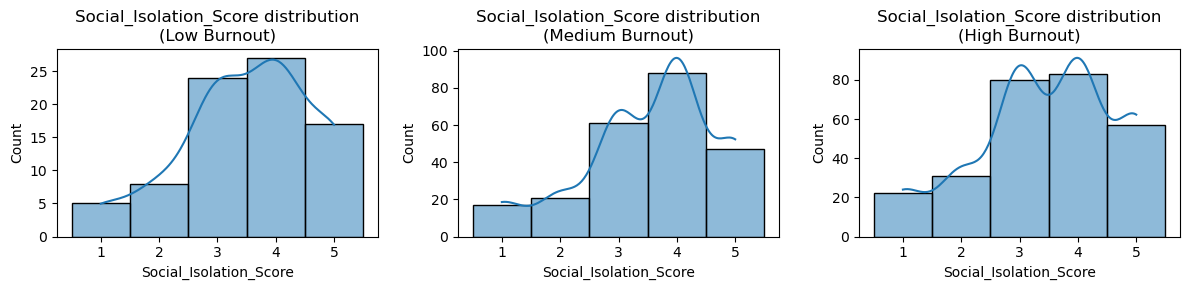

In [13]:
plot_boxplots('Social_Isolation_Score')

`Social_Isolation_Score` shows densities skewing more right as burnout level increases, indicating that higher social isolation is associated with higher burnout levels.

/Users/mandeepsaini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mandeepsaini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mandeepsaini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


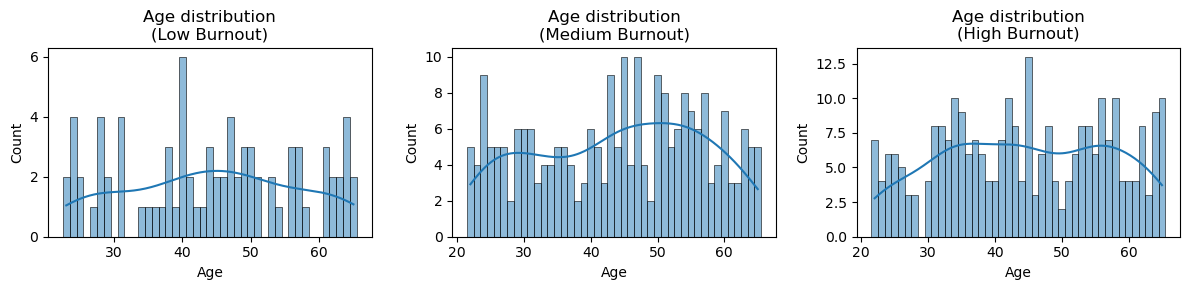

In [14]:
plot_boxplots('Age')

The `Age` distribution remote workers experiencing Low burnout is normal, while medium and high burnout show a right skew, indicating that younger workers are less likely to experience burnout.

/Users/mandeepsaini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mandeepsaini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mandeepsaini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


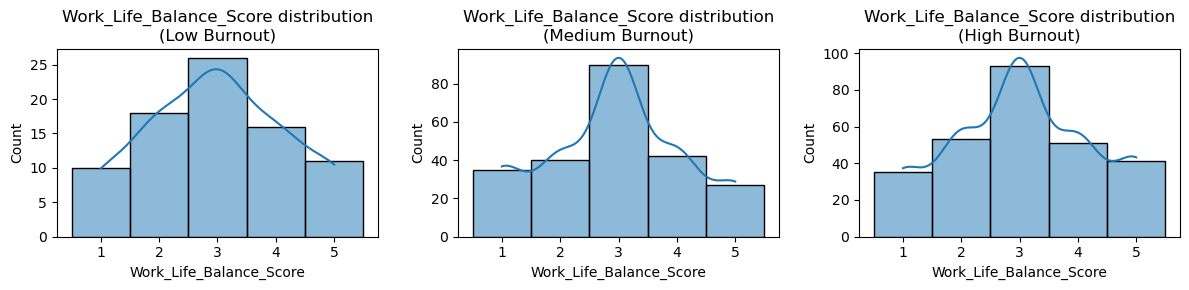

In [15]:
plot_boxplots('Work_Life_Balance_Score')

The `Work_Life_Balance_Score` distribution for medium and high burnout levels are more concentrated around the middle of the scale, indicating that individuals with medium and high burnout have less favorable work-life balance compared to those with low burnout.

/Users/mandeepsaini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mandeepsaini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mandeepsaini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


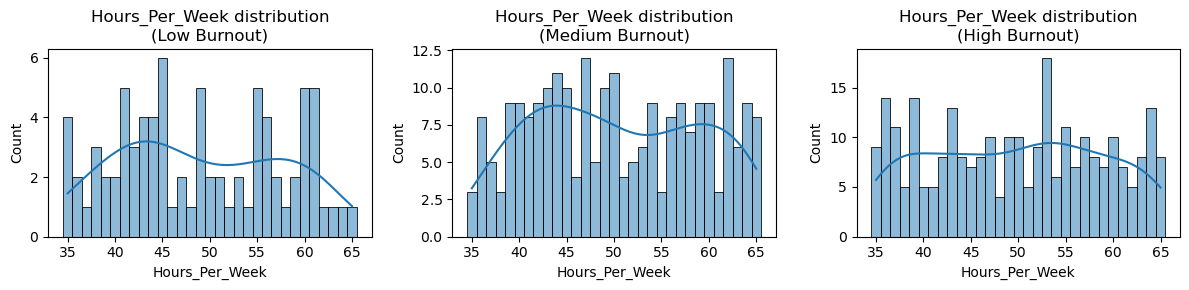

In [16]:
plot_boxplots('Hours_Per_Week')

The `Hours_Per_Week` distribution shifts from a left-skewed distribution to a more uniform distribution as burnout levels increase, indicating that individuals with higher burnout levels tend to work more hours per week.

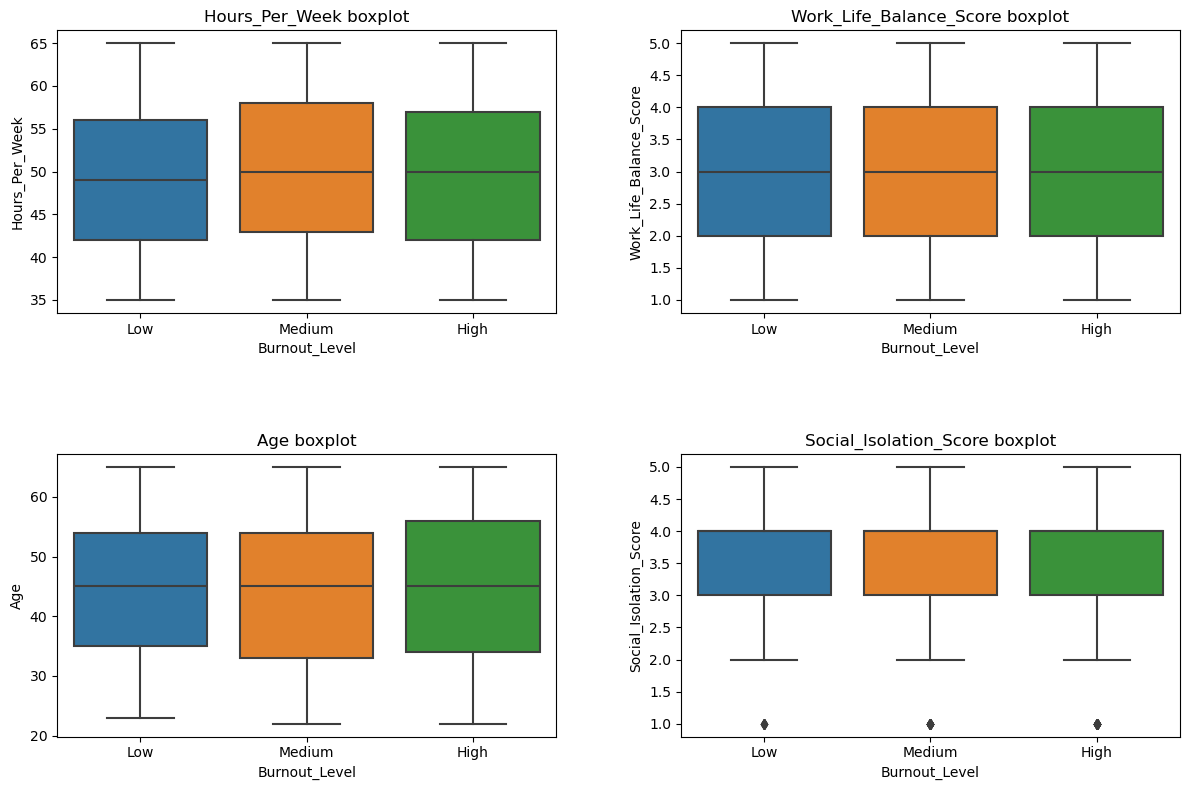

In [17]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(df_numerical.columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(
        x=df_categorical["Burnout_Level"],
        y=df_numerical[col],
        order=["Low", "Medium", "High"],
    )
    plt.title(f"{col} boxplot")
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.25)
plt.show()

The boxplot visualizations show that `Social_Isolation_Score` and `Work_Life_Balance_Score` have similar shapes across the different burnout categories.  

`Hours_Per_Week` shows a slight increase in the median and interquartile range as burnout levels increase. This suggests that individuals who work more hours are more likely to experience higher levels of burnout.  

`Age` shows the same median across all burnout levels, but the interquartile range widens as burnout levels increase, indicating more variability in age among those with higher burnout levels.

In [18]:
def plot_violin(col):
    sns.violinplot(
        x="Burnout_Level",
        y=col,
        data=pd.concat([df_categorical["Burnout_Level"], df_numerical], axis=1),
        inner="box",
        cut=0,
        order=["Low", "Medium", "High"],
        palette="Blues",
        hue="Burnout_Level",
        hue_order=["Low", "Medium", "High"],
    )
    plt.title(f"{col} by burnout level")
    plt.subplots_adjust(hspace=0.5, wspace=0.25)
    plt.show()

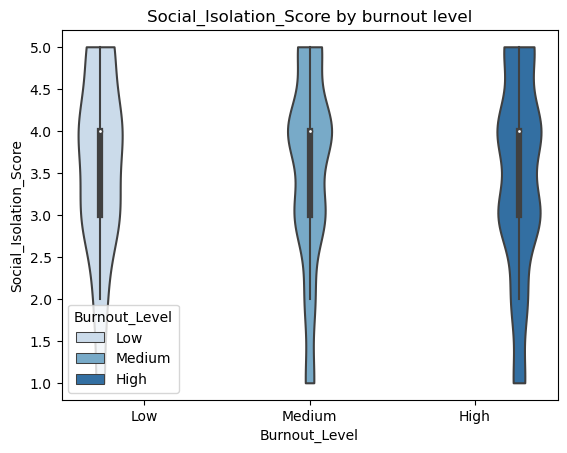

In [19]:
plot_violin('Social_Isolation_Score')

As `Burnout_Level` increases, the distribution of `Social_Isolation_Score` becomes more right skewed, indicating that individuals with higher burnout levels tend to experience higher social isolation.

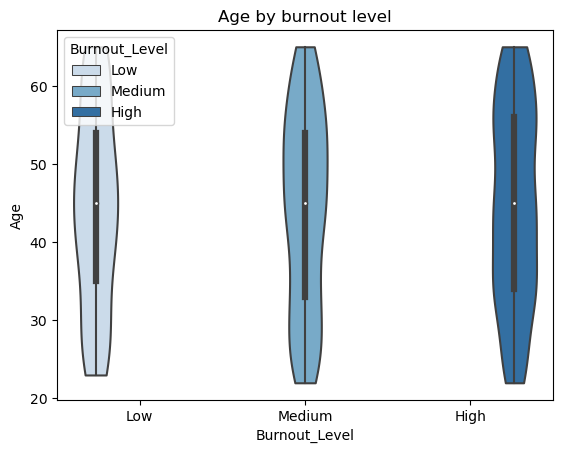

In [20]:
plot_violin('Age')

As `Burnout_Level` increases, the density of `Age` becomes more uniform, indicating that individuals with higher burnout levels are more evenly distributed across different age groups.

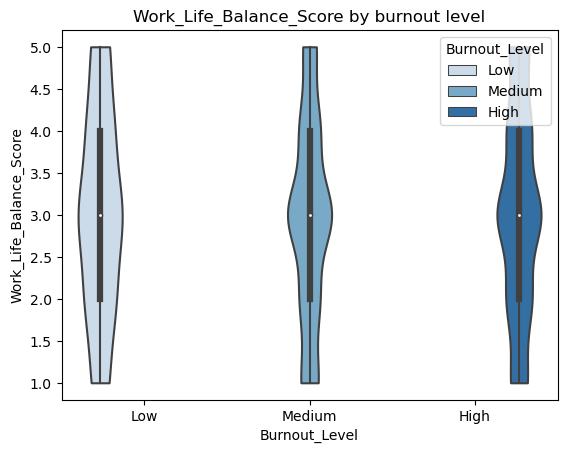

In [21]:
plot_violin('Work_Life_Balance_Score')

As `Burnout_Level` increases, the `Work_Life_Balance_Score` becomes more concentrated around the middle of the scale, indicating that individuals with higher burnout levels have less favorable work-life balance. Interestingly, there is a higher density of individuals with Low burnout who also have low `Work_Life_Balance_Score`, suggesting that some individuals with low burnout may still struggle with work-life balance.

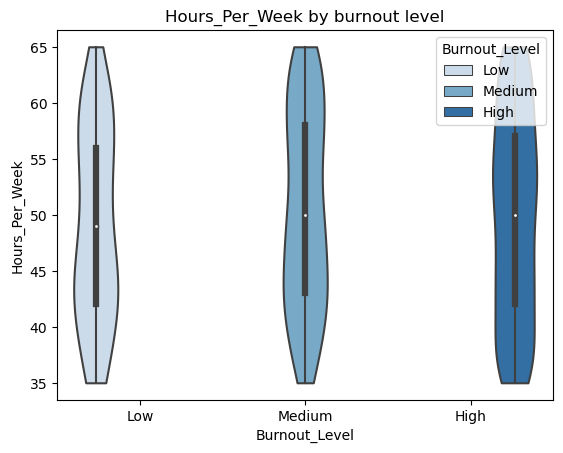

In [22]:
plot_violin('Hours_Per_Week')

As `Burnout_Level` increases, the density of `Hours_Per_Week` shifts from left skewed to right skewed and the median increases, indicating that individuals with higher burnout levels tend to work more hours per week.

/Users/mandeepsaini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mandeepsaini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mandeepsaini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mandeepsaini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

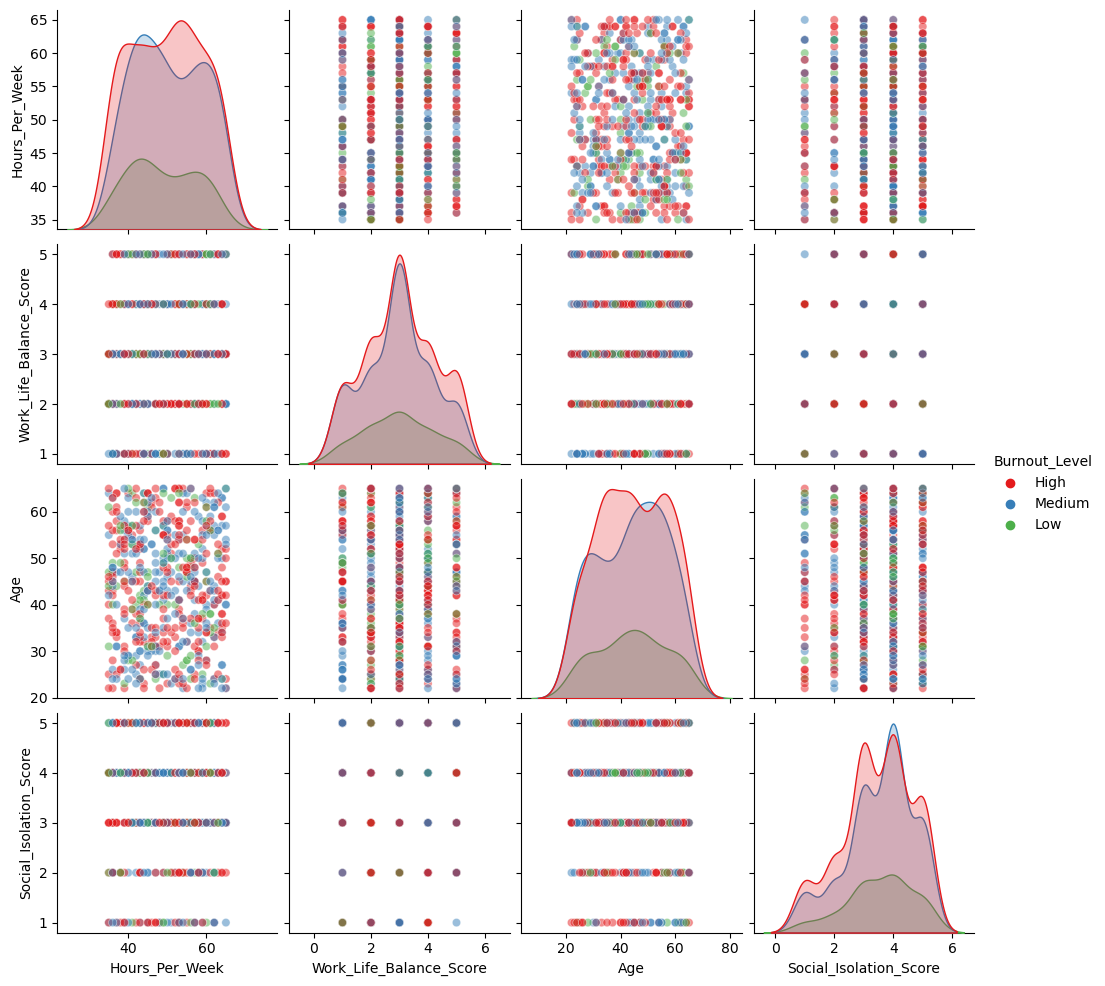

In [23]:
sns.pairplot(
    df_remote,
    vars=df_numerical.columns,
    diag_kind="kde",
    plot_kws={"alpha": 0.5},
    height=2.5,
    palette="Set1",
    hue="Burnout_Level",
    hue_order=["High", "Medium", "Low"],
)
plt.show()

- `Social_Isolation_Score` is positively correlated with burnout levels, with higher scores indicating larger densities in the medium and high burnout categories.
- `Work_Life_Balance_Score` shows a negative correlation with burnout levels, where lower scores are associated with larger densities in the medium and high burnout categories.

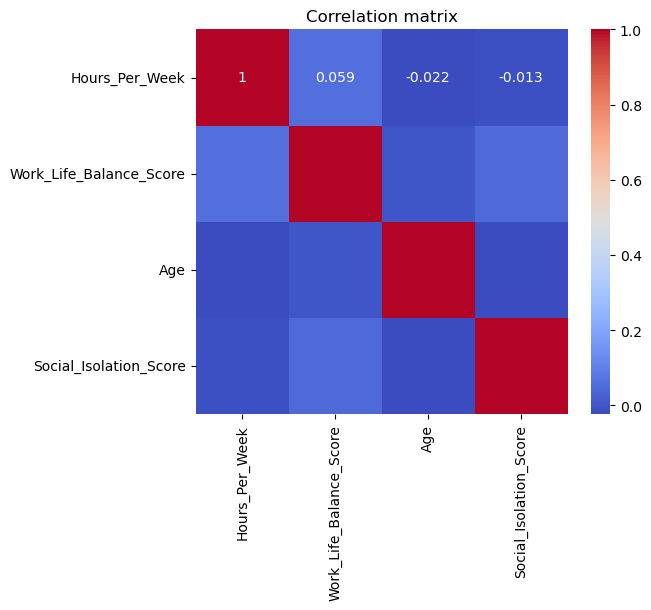

In [24]:
plt.figure(figsize=(6, 5))
corr = df_numerical.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

None of the numerical features show correlation with each other, indicating that they are all independent of each other.

## Significance Testing

In [25]:
print("T-test for Low vs Medium and High Burnout Levels")
ttest_ind_results = []
for col in numericals_cols:
    group1 = df_remote[df_remote["Burnout_Level"] != "Low"][col]
    group0 = df_remote[df_remote["Burnout_Level"] == "Low"][col]
    t_stat, p_val = ttest_ind(group1, group0, equal_var=False)
    ttest_ind_results.append(
        {
            "Column": col,
            "T-statistic": t_stat,
            "P-value": p_val,
            "Conclusion": (
                "Significant difference"
                if p_val < 0.05
                else "No significant difference"
            ),
        }
    )
ttest_ind_results_df = pd.DataFrame(ttest_ind_results)
display(ttest_ind_results_df)

T-test for Low vs Medium and High Burnout Levels


,Column,T-statistic,P-value,Conclusion
0,Hours_Per_Week,1.038625,0.301262,No significant difference
1,Work_Life_Balance_Score,-0.054331,0.956773,No significant difference
2,Age,-0.009474,0.992458,No significant difference
3,Social_Isolation_Score,-0.295540,0.768144,No significant difference


The t-tests results indicate that there are no significant differences between the `High+Medium` and `Low` burnout groups for the quantitative features. This suggests that the differences in the distributions of these features across burnout levels are not statistically significant.

In [26]:
print("T-test for Low vs High Burnout Levels")
ttest_ind_results = []
for col in numericals_cols:
    group1 = df_remote[df_remote["Burnout_Level"] == "High"][col]
    group0 = df_remote[df_remote["Burnout_Level"] == "Low"][col]
    t_stat, p_val = ttest_ind(group1, group0, equal_var=False)
    ttest_ind_results.append(
        {
            "Column": col,
            "T-statistic": t_stat,
            "P-value": p_val,
            "Conclusion": (
                "Significant difference"
                if p_val < 0.05
                else "No significant difference"
            ),
        }
    )
ttest_ind_results_df = pd.DataFrame(ttest_ind_results)
display(ttest_ind_results_df)

T-test for Low vs High Burnout Levels


,Column,T-statistic,P-value,Conclusion
0,Hours_Per_Week,0.745805,0.457053,No significant difference
1,Work_Life_Balance_Score,0.237940,0.812296,No significant difference
2,Age,0.127038,0.899106,No significant difference
3,Social_Isolation_Score,-0.586307,0.558637,No significant difference


The t-tests results indicate that there are no significant differences between the `High` and `Low` burnout groups for the quantitative features. This suggests that the differences in the distributions of these features across burnout levels are not statistically significant.

In [27]:
chi2_results = []
for col in categorical_cols:
    if col == "Burnout_Level":
        continue
    contingency_table = pd.crosstab(df_remote[col], df_remote["Burnout_Level"])
    chi2_stat, p_val_chi2, dof, expected = chi2_contingency(contingency_table)
    chi2_results.append(
        {
            "Column": col,
            "Chi-squared Statistic": chi2_stat,
            "P-value": p_val_chi2,
            "Conclusion": (
                "Association exists" if p_val_chi2 < 0.05 else "No association"
            ),
        }
    )
chi2_results_df = pd.DataFrame(chi2_results)
display(chi2_results_df)

,Column,Chi-squared Statistic,P-value,Conclusion
0,Mental_Health_Status,15.017915,0.240458,No association
1,Work_Arrangement,0.000000,1.000000,No association
2,Gender,2.910426,0.820002,No association
3,Region,12.173529,0.273611,No association
4,Job_Role,40.048894,0.718729,No association
5,Industry,22.703213,0.121902,No association
6,Shoulder_Pain,0.618908,0.733848,No association
7,Wrist_Pain,10.028816,0.006642,Association exists
8,Eye_Strain,1.726253,0.421841,No association
9,Salary_Range,4.090046,0.848909,No association


The chi-squared test results indicate that only `Wrist_Pain` has an association with burnout levels, suggesting that individuals with wrist pain are more likely to experience higher levels of burnout.  

The other categorical features do not show significant associations with burnout levels, indicating that they may not be strong predictors of burnout.

In [42]:
#Target
mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df_remote['Burnout_Level_Num'] = df_remote['Burnout_Level'].map(mapping)
y = df_remote['Burnout_Level_Num']

#Features
feature_cols = ['Age', 'Hours_Per_Week', 'Work_Life_Balance_Score', 'Social_Isolation_Score',
    'Back_Pain', 'Shoulder_Pain', 'Neck_Pain', 'Eye_Strain', 'Wrist_Pain',
    'No_Physical_Health_Issues',]
X = df_remote[feature_cols]

from IPython.display import display
display(X.head())
display(y.value_counts())


,Age,Hours_Per_Week,Work_Life_Balance_Score,Social_Isolation_Score,Back_Pain,Shoulder_Pain,Neck_Pain,Eye_Strain,Wrist_Pain,No_Physical_Health_Issues
8,30,47,2,4,False,False,True,False,False,False
11,64,35,3,4,False,False,False,True,True,False
13,37,59,5,5,True,True,False,False,True,False
14,50,64,1,4,False,False,False,False,False,True
19,27,43,1,4,False,False,False,False,False,True


Burnout_Level_Num
2    273
1    234
0     81
Name: count, dtype: int64

In [48]:
#Train/test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#Apple SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


print(y_train_bal.value_counts())



Burnout_Level_Num
1    218
2    218
0    218
Name: count, dtype: int64


In [44]:
#Scale Numeric Features
from sklearn.preprocessing import StandardScaler

numeric_cols = ['Age', 'Hours_Per_Week', 'Work_Life_Balance_Score', 'Social_Isolation_Score']
scaler = StandardScaler()
X_train_bal[numeric_cols] = scaler.fit_transform(X_train_bal[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

#Train Model 
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_bal, y_train_bal)

#Predict and Evaluate
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))
print(confusion_matrix(y_test, y_pred))


#### Random Forest Results

- The model did a fair job identifying people at **High** burnout (about 60% recall, 52% precision).
- It was able to find some **Medium** burnout cases (34% recall).
- However, it completely missed people in the **Low** burnout group (0% recall and precision).
- This means the model mostly grouped everyone as Medium or High, and could not spot the people who are doing well.
- Overall, accuracy was about 42%, just a little better than random guessing for three groups.


In [50]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(
    multi_class='multinomial',
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)
clf_lr.fit(X_train_bal, y_train_bal)
y_pred_lr = clf_lr.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_lr, target_names=['Low', 'Medium', 'High']))
print(confusion_matrix(y_test, y_pred_lr))


              precision    recall  f1-score   support

         Low       0.14      0.31      0.19        16
      Medium       0.47      0.38      0.42        47
        High       0.60      0.47      0.53        55

    accuracy                           0.42       118
   macro avg       0.40      0.39      0.38       118
weighted avg       0.49      0.42      0.44       118

[[ 5  5  6]
 [18 18 11]
 [14 15 26]]


#### Logistic Regression Results

- This model did a better job than Random Forest at catching the **Low** burnout group (31% recall, 14% precision), even if still not great.
- It was also able to identify some **Medium** (38% recall) and **High** burnout cases (47% recall).
- Overall accuracy stayed about the same (42%), but at least now the model isn’t missing all the “Low” cases.
- Still, the model often confused people between the groups, showing it’s a tough prediction problem.


In [51]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Fit model (set num_class=3 for your three burnout classes)
clf_xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    random_state=42
)
clf_xgb.fit(X_train_bal, y_train_bal)

# Predict
y_pred_xgb = clf_xgb.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred_xgb, target_names=['Low', 'Medium', 'High']))
print(confusion_matrix(y_test, y_pred_xgb))


              precision    recall  f1-score   support

         Low       0.00      0.00      0.00        16
      Medium       0.38      0.40      0.39        47
        High       0.54      0.49      0.51        55

    accuracy                           0.39       118
   macro avg       0.31      0.30      0.30       118
weighted avg       0.40      0.39      0.40       118

[[ 0 10  6]
 [11 19 17]
 [ 7 21 27]]


#### Why We Switched to Binary Classification

We first attempted to classify burnout as Low, Medium, or High using Random Forest, Logistic Regression, and XGBoost. All three models struggled to identify the “Low” burnout group, with precision and recall close to zero for that class. After multiple attempts, we decided to merge the “Low” and “Medium” categories into a single “Not High” group and focus on predicting “High” burnout, which is the most actionable outcome for workplace interventions.


In [52]:
# Make a new binary target: 1 = High, 0 = Not High (Low or Medium)
df_remote['Burnout_Binary'] = df_remote['Burnout_Level'].apply(lambda x: 1 if x == 'High' else 0)
y = df_remote['Burnout_Binary']


In [53]:
#Repeating last models after binary  classification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_bal, y_train_bal)

from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Not High', 'High']))
print(confusion_matrix(y_test, y_pred))




              precision    recall  f1-score   support

    Not High       0.52      0.54      0.53        63
        High       0.44      0.42      0.43        55

    accuracy                           0.48       118
   macro avg       0.48      0.48      0.48       118
weighted avg       0.48      0.48      0.48       118

[[34 29]
 [32 23]]


In [ ]:
#### Model Results

- The model is only right about half the time (48% accuracy).
- When it predicts “High” burnout, it’s right less than half the time (44% precision).
- It finds less than half of the true “High” burnout cases (42% recall).
- The confusion matrix shows the model mixes up “High” and “Not High” a lot.

Overall: The model has a hard time telling who has high burnout and who doesn’t.


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

clf_lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
clf_lr.fit(X_train_bal, y_train_bal)
y_pred_lr = clf_lr.predict(X_test)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr, target_names=['Not High', 'High']))
print(confusion_matrix(y_test, y_pred_lr))


Logistic Regression Results:
              precision    recall  f1-score   support

    Not High       0.52      0.44      0.48        63
        High       0.45      0.53      0.49        55

    accuracy                           0.48       118
   macro avg       0.49      0.49      0.48       118
weighted avg       0.49      0.48      0.48       118

[[28 35]
 [26 29]]


In [55]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(objective='binary:logistic', random_state=42)
clf_xgb.fit(X_train_bal, y_train_bal)
y_pred_xgb = clf_xgb.predict(X_test)

print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb, target_names=['Not High', 'High']))
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost Results:
              precision    recall  f1-score   support

    Not High       0.51      0.59      0.55        63
        High       0.43      0.36      0.40        55

    accuracy                           0.48       118
   macro avg       0.47      0.48      0.47       118
weighted avg       0.48      0.48      0.48       118

[[37 26]
 [35 20]]


In [56]:
from sklearn.svm import SVC

clf_svc = SVC(class_weight='balanced', probability=True, random_state=42)
clf_svc.fit(X_train_bal, y_train_bal)
y_pred_svc = clf_svc.predict(X_test)

print("SVM Results:")
print(classification_report(y_test, y_pred_svc, target_names=['Not High', 'High']))
print(confusion_matrix(y_test, y_pred_svc))


SVM Results:
              precision    recall  f1-score   support

    Not High       0.42      0.40      0.41        63
        High       0.36      0.38      0.37        55

    accuracy                           0.39       118
   macro avg       0.39      0.39      0.39       118
weighted avg       0.39      0.39      0.39       118

[[25 38]
 [34 21]]


#### Comparing Binary Models (High vs. Not High Burnout)

- **Logistic Regression:**  
  - Found about half of each group, but often mixed them up.
  - 48% accuracy.
  - The model was almost equally likely to mislabel someone as High or Not High.

- **XGBoost:**  
  - Slightly better at finding people who are truly Not High (59% recall), but still struggled with High cases (36% recall).
  - Also about 48% accuracy.

- **SVM:**  
  - Did the worst, with less than 40% accuracy.
  - Frequently confused the two groups.

**Bottom line:**  
All models had trouble telling who is truly at high risk for burnout and who is not. The available data didn’t have enough signal to make strong predictions.
